Simple Linear Regression model
==============================
Most tutorials start with some nice and pretty image classification problem to illustrate how to use PyTorch. It may seem cool, but I believe it distracts you from the main goal: how PyTorch works?
For this reason, in this tutorial, I will stick with a simple and familiar problem: a linear regression with a single feature x! It doesn’t get much simpler than that…
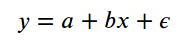
Data Generation
---------------
Let’s start generating some synthetic data: we start with a vector of 100 points for our feature x and create our labels using a = 1, b = 2 and some Gaussian noise.
Next, let’s split our synthetic data into train and validation sets, shuffling the array of indices and using the first 80 shuffled points for training.

In [17]:
%matplotlib inline

In [1]:
np.random.seed(20)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [2]:
import matplotlib.pyplot as plt
plt.scatter(x_train, y_train, label='train data')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("train data")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


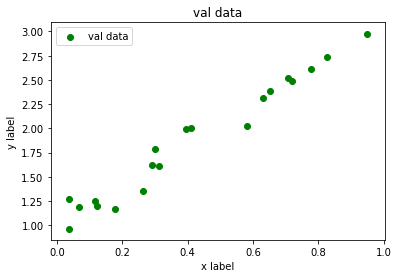

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x_val, y_val, label='val data',color='g')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("val data")
plt.legend()
plt.show()

We know that a = 1 and b = 2, but now let’s see how close we can get to the true values by using gradient descent and the 80 points in the training set…

Gradient Descent
------------------------
I’ll cover the four basic steps you’d need to go through to compute it.  
Step 1: Compute the Loss
For a regression problem, the loss is given by the Mean Square Error (MSE), that is, the average of all squared differences between labels (y) and predictions (a + bx).
It is worth mentioning that, if we use all points in the training set (N) to compute the loss, we are performing a batch gradient descent. If we were to use a single point at each time, it would be a stochastic gradient descent. Anything else (n) in-between 1 and N characterizes a mini-batch gradient descent.
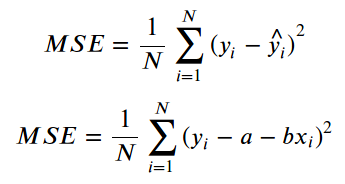
<center>Loss: Mean Squared Error (MSE)

Step 2: Compute the Gradients
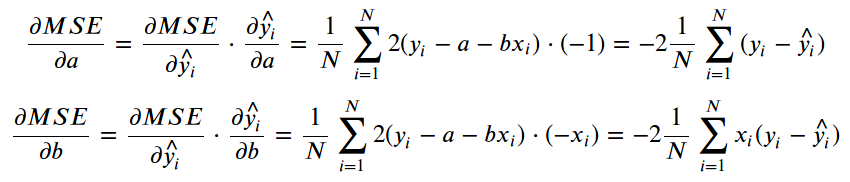   
A gradient is a partial derivative — why partial? Because one computes it with respect to (w.r.t.) a single parameter. We have two parameters, a and b, so we must compute two partial derivatives.
A derivative tells you how much a given quantity changes when you slightly vary some other quantity. In our case, how much does our MSE loss change when we vary each one of our two parameters?
The right-most part of the equations below is what you usually see in implementations of gradient descent for a simple linear regression. In the intermediate step, I show you all elements that pop-up from the application of the chain rule, so you know how the final expression came to be.
Computing gradients w.r.t coefficients a and b

Step 3: Update the Parameters  
In the final step, we use the gradients to update the parameters. Since we are trying to minimize our losses, we reverse the sign of the gradient for the update.
There is still another parameter to consider: the learning rate, denoted by the Greek letter eta (that looks like the letter n), which is the multiplicative factor that we need to apply to the gradient for the parameter update.

Updating coefficients a and b using computed gradients and a learning rate
How to choose a learning rate? That is a topic on its own and beyond the scope of this post as well.
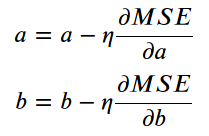

Step 4: Rinse and Repeat!  
Now we use the updated parameters to go back to Step 1 and restart the process.
An epoch is complete whenever every point has been already used for computing the loss. For batch gradient descent, this is trivial, as it uses all points for computing the loss — one epoch is the same as one update. For stochastic gradient descent, one epoch means N updates, while for mini-batch (of size n), one epoch has N/n updates.
Repeating this process over and over, for many epochs, is, in a nutshell, training a model.

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [24]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.2345], requires_grad=True) tensor([0.2303], requires_grad=True)
tensor([-1.1229], device='cuda:0', grad_fn=<CopyBackwards>) tensor([-0.1863], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([2.2082], device='cuda:0', requires_grad=True) tensor([-0.6380], device='cuda:0', requires_grad=True)


In PyTorch, every method that ends with an underscore (_) makes changes in-place, meaning, they will modify the underlying variable.

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.  
So, how do we tell PyTorch to do its thing and compute all gradients? That’s what backward() is good for.
Do you remember the starting point for computing the gradients? It was the loss, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the backward() method from the corresponding Python variable, like, loss.backward().
What about the actual values of the gradients? We can inspect them by looking at the grad attribute of a tensor.

In [25]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
loss_list=[]
for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.item())

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.6260], device='cuda:0')
tensor([-2.2105], device='cuda:0')
tensor([-2.6612], device='cuda:0')
tensor([-1.6591], device='cuda:0')
tensor([-1.9491], device='cuda:0')
tensor([-1.2518], device='cuda:0')
tensor([-1.4235], device='cuda:0')
tensor([-0.9509], device='cuda:0')
tensor([-1.0357], device='cuda:0')
tensor([-0.7285], device='cuda:0')
tensor([-0.7496], device='cuda:0')
tensor([-0.5641], device='cuda:0')
tensor([-0.5385], device='cuda:0')
tensor([-0.4424], device='cuda:0')
tensor([-0.3828], device='cuda:0')
tensor([-0.3524], device='cuda:0')
tensor([-0.2681], device='cuda:0')
tensor([-0.2856], device='cuda:0')
tensor([-0.1835], device='cuda:0')
tensor([-0.2361], device='cuda:0')
tensor([-0.1212], device='cuda:0')
tensor([-0.1993], device='cuda:0')
tensor([-0.0753], device='cuda:0')
tensor([-0.1719], device='cuda:0')
tensor([-0.0416], device='cuda:0')
tensor([-0.1514], device='cuda:0')
tensor([-0.0169], device='cuda:0')
tensor([-0.1361], device='cuda:0')
tensor([0.0012], dev

tensor([0.0083], device='cuda:0')
tensor([-0.0146], device='cuda:0')
tensor([0.0082], device='cuda:0')
tensor([-0.0145], device='cuda:0')
tensor([0.0082], device='cuda:0')
tensor([-0.0143], device='cuda:0')
tensor([0.0081], device='cuda:0')
tensor([-0.0142], device='cuda:0')
tensor([0.0080], device='cuda:0')
tensor([-0.0140], device='cuda:0')
tensor([0.0079], device='cuda:0')
tensor([-0.0139], device='cuda:0')
tensor([0.0078], device='cuda:0')
tensor([-0.0138], device='cuda:0')
tensor([0.0078], device='cuda:0')
tensor([-0.0136], device='cuda:0')
tensor([0.0077], device='cuda:0')
tensor([-0.0135], device='cuda:0')
tensor([0.0076], device='cuda:0')
tensor([-0.0134], device='cuda:0')
tensor([0.0075], device='cuda:0')
tensor([-0.0132], device='cuda:0')
tensor([0.0075], device='cuda:0')
tensor([-0.0131], device='cuda:0')
tensor([0.0074], device='cuda:0')
tensor([-0.0130], device='cuda:0')
tensor([0.0073], device='cuda:0')
tensor([-0.0128], device='cuda:0')
tensor([0.0073], device='cuda:0')


tensor([0.0010], device='cuda:0')
tensor([-0.0018], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0018], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0018], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0010], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0017], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0016], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0016], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0016], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0016], device='cuda:0')
tensor([0.0009], device='cuda:0')
tensor([-0.0016], device='cuda:0')
tensor([0.0009], device='cuda:0')


tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')
tensor([-0.0002], device='cuda:0')
tensor([0.0001], device='cuda:0')


tensor([-3.1113e-05], device='cuda:0')
tensor([1.7405e-05], device='cuda:0')
tensor([-3.0844e-05], device='cuda:0')
tensor([1.7311e-05], device='cuda:0')
tensor([-3.0503e-05], device='cuda:0')
tensor([1.7207e-05], device='cuda:0')
tensor([-3.0152e-05], device='cuda:0')
tensor([1.7133e-05], device='cuda:0')
tensor([-2.9791e-05], device='cuda:0')
tensor([1.6768e-05], device='cuda:0')
tensor([-2.9630e-05], device='cuda:0')
tensor([1.6540e-05], device='cuda:0')
tensor([-2.9388e-05], device='cuda:0')
tensor([1.6287e-05], device='cuda:0')
tensor([-2.9160e-05], device='cuda:0')
tensor([1.6158e-05], device='cuda:0')
tensor([-2.8873e-05], device='cuda:0')
tensor([1.6071e-05], device='cuda:0')
tensor([-2.8544e-05], device='cuda:0')
tensor([1.5965e-05], device='cuda:0')
tensor([-2.8233e-05], device='cuda:0')
tensor([1.5840e-05], device='cuda:0')
tensor([-2.7945e-05], device='cuda:0')
tensor([1.5732e-05], device='cuda:0')
tensor([-2.7627e-05], device='cuda:0')
tensor([1.5717e-05], device='cuda:0')

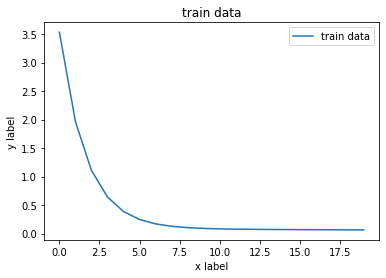

In [26]:
plt.plot(loss_list[0:20], label='train data')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("train data")
plt.legend()
plt.show()

Optimizer
---------
So far, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like SGD or Adam.
An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.
Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!
In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters a and b.
Don’t be fooled by the optimizer’s name: if we use all training data at once for the update — as we are actually doing in the code — the optimizer is performing a batch gradient descent, despite of its name.

In [27]:
torch.manual_seed(20)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.0784], device='cuda:0', requires_grad=True) tensor([1.2082], device='cuda:0', requires_grad=True)
tensor([0.9707], device='cuda:0', requires_grad=True) tensor([2.0509], device='cuda:0', requires_grad=True)


In [28]:
np.random.seed(20)
x1 = np.random.rand(100, 1)
x2 = np.random.rand(100, 1)
y = 3*x1*x1 + 2 * x2 + 3 +  .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x1_train,x2_train, y_train = x1[train_idx], x2[train_idx], y[train_idx]
x1_val,x2_val, y_val = x1[val_idx], x2[val_idx], y[val_idx]

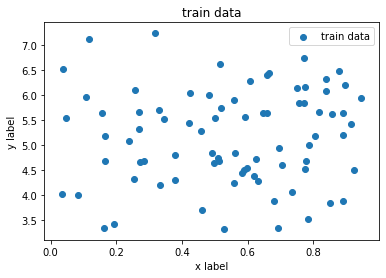

In [29]:
import matplotlib.pyplot as plt
plt.scatter(x_train, y_train, label='train data')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("train data")
plt.legend()
plt.show()

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x1_train_tensor = torch.from_numpy(x1_train).float().to(device)
x2_train_tensor = torch.from_numpy(x2_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)


In [31]:
torch.manual_seed(20)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
c = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b, c)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b, c], lr=lr)

loss_list = []
for epoch in range(n_epochs):
    yhat = a * x1_train_tensor * x1_train_tensor + b * x2_train_tensor + c
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)
    loss_list.append(loss.item())
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b, c)

tensor([-0.0784], device='cuda:0', requires_grad=True) tensor([1.2082], device='cuda:0', requires_grad=True) tensor([-0.2656], device='cuda:0', requires_grad=True)
tensor([2.8921], device='cuda:0', requires_grad=True) tensor([1.9169], device='cuda:0', requires_grad=True) tensor([3.0835], device='cuda:0', requires_grad=True)


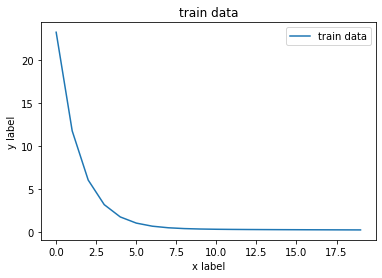

In [32]:
plt.plot(loss_list[0:20], label='train data')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("train data")
plt.legend()
plt.show()

Model 
---------
In PyTorch, a model is represented by a regular Python class that inherits from the Module class.
The most fundamental methods it needs to implement are:
__init__(self): it defines the parts that make up the model —in our case, two parameters, a and b.

forward(self, x): it performs the actual computation, that is, it outputs a prediction, given the input x.  
You should NOT call the forward(x) method, though. You should call the whole model itself, as in model(x) to perform a forward pass and output predictions.
Let’s build a proper (yet simple) model for our regression task. It should look like this:

In [4]:
import torch
from torch import nn
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [34]:
model_a = ManualLinearRegression()

In the __init__ method, we define our two parameters, a and b, using the Parameter() class, to tell PyTorch these tensors should be considered parameters of the model they are an attribute of.
Moreover, we can get the current values for all parameters using our model’s state_dict() method.

we need to send our model to the same device where the data is. If our data is made of GPU tensors, our model must “live” inside the GPU as well.

In [8]:
torch.manual_seed(42)
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='cuda:0')), ('b', tensor([0.1288], device='cuda:0'))])
OrderedDict([('a', tensor([0.9707], device='cuda:0')), ('b', tensor([2.0509], device='cuda:0'))])


Nested Models  
-------------

In our model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model.
Even though this clearly is a contrived example, as we are pretty much wrapping the underlying model without adding anything useful (or, at all!) to it, it illustrates well the concept.
In the __init__ method, we created an attribute that contains our nested Linear model.
In the forward() method, we call the nested model itself to perform the forward pass (notice, we are not calling self.linear.forward(x)!).

In [9]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1,bias=False)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

Training Step  
-----------
So far, we’ve defined an optimizer, a loss function and a model. Scroll up a bit and take a quick look at the code inside the loop. Would it change if we were using a different optimizer, or loss, or even model? If not, how can we make it more generic?
Well, I guess we could say all these lines of code perform a training step, given those three elements (optimizer, loss and model),the features and the labels.
So, how about writing a function that takes those three elements and returns another function that performs a training step, taking a set of features and labels as arguments and returning the corresponding loss?
Then we can use this general-purpose function to build a train_step() function to be called inside our training loop. Now our code should look like this… see how tiny the training loop is now?

In [10]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([0.9707], device='cuda:0')), ('b', tensor([2.0509], device='cuda:0'))])


In [ ]:
#####

Dataset  
-------
In PyTorch, a dataset is represented by a regular Python class that inherits from the Dataset class. You can think of it as a kind of a Python list of tuples, each tuple corresponding to one point (features, label).  
The most fundamental methods it needs to implement are:  
__init__(self) : it takes whatever arguments needed to build a list of tuples — it may be the name of a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand.
There is no need to load the whole dataset in the constructor method (__init__). If your dataset is big (tens of thousands of image files, for instance), loading it at once would not be memory efficient. It is recommended to load them on demand (whenever __get_item__ is called).  
__get_item__(self, index): it allows the dataset to be indexed, so it can work like a list (dataset[i]) — it must return a tuple (features, label) corresponding to the requested data point. We can either return the corresponding slices of our pre-loaded dataset or tensors or, as mentioned above, load them on demand (like in this example).  
__len__(self): it should simply return the size of the whole dataset so, whenever it is sampled, its indexing is limited to the actual size.
Let’s build a simple custom dataset that takes two tensors as arguments: one for the features, one for the labels. For any given index, our dataset class will return the corresponding slice of each of those tensors. It should look like this:

In [5]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

NameError: name 'torch' is not defined

In [ ]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

In [25]:
from  torch.optim import lr_scheduler
#Assuming optimizer has two groups.
lambda1 = lambda epoch: epoch // 30
lambda2 = lambda epoch: 0.95 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
for epoch in range(100):
    
    scheduler.step()
    print(optimizer.param_groups[0]['lr'])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004


/home/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [20]:
optimizer.param_groups[0]

{'params': [Parameter containing:
  tensor([0.9707], device='cuda:0', requires_grad=True), Parameter containing:
  tensor([2.0509], device='cuda:0', requires_grad=True)],
 'lr': 0.30000000000000004,
 'momentum': 0,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'initial_lr': 0.1}